Data on confirmed COVID-19 cases in Scotland by Health board taken from the Web Archive [WayBackMachine](https://web.archive.org/web/*/https://www. gov.scot/coronavirus-covid-19/) capture of the Scottish Government published health board data published since 2020-03-05 ( broken down by specific health boards ).

In [3]:
pip install html2text lxml matplotlib pandas word2number xarray 

Note: you may need to restart the kernel to use updated packages.


In [19]:
from datetime import datetime
from pathlib import Path

from html2text import html2text
from dateutil import parser
from word2number import w2n
import pandas as pd
import urllib
import xarray as xr

In [5]:
class ScotlandCOVID19():
    
    def __init__(self, html: str, archive_copy: bool = False, date_requested: str = None):
        self.html = html
        self.date_requested = date_requested
        self.lines = self.parse_html()
        self.archive_copy = archive_copy
        self.date = self.parse_date()
        self.counts = self.get_counts()
        self.deaths = self.get_number_of_deaths()
        self.tests = self.get_num_tests()
        
    def __repr__(self):
        return "Date: " + str(self.date)[:10] + "\nNumbe of tests concluded to date: " + str(self.tests) + \
            "\nPatient deaths of confirmed cases to date: " + str(self.deaths) + \
            "\n" + str(self.counts)
        
    @classmethod
    def from_latest_government(cls):
        print("Latest")
        html = str(urllib.request.urlopen('https://www.gov.scot/coronavirus-covid-19').read())
        return cls(html)
        
    @classmethod
    def from_date(cls, date: str):
        print(date)
        url =  "https://web.archive.org/web/" + date + \
            "/https://www.gov.scot/coronavirus-covid-19"
        html = str(urllib.request.urlopen(url).read())
        return cls(html, archive_copy=True, date_requested=date)

    def parse_html(self) -> list:
        lines = html2text(self.html).replace('\n','').split('\\n')
        new_lines = []
        for line in lines:
            if line != '':
                new_lines.append(lines)
        return new_lines
    
    def parse_date(self) -> str:
        """Parses the publication date from the line below the published table"""
        for line in self.lines:
            line = ''.join(line)
            if 'updated' in line:
                index = line.find('Last updated')
                if index != -1:
                    substring = line[index + 10: index + 50].split('.')[0][-13:]
                    print(substring)
                    return pd.to_datetime(substring)
        
    def get_number_of_deaths(self) -> int:
        index = self.html.find('Sadly,')
        if index != -1:
            return w2n.word_to_num(self.html[index+7:index+20].split(' ')[0])
        index = self.html.find('patients who')
        if index != -1:
            return int(self.html[index-5:index].split('>')[1])
        return 0
    
    def get_num_tests(self) -> int:
        index = self.html.find('A total of')
        substring = self.html[index+11:index+21].split()[0]
        for char in [';','>']:
            if char in substring:
                substring = substring.split(char)[1]
        return int(substring.replace(',',''))
    
    def get_counts(self) -> pd.DataFrame:
        tables = pd.read_html(self.html)
        if len(tables) >= 3 and self.archive_copy:
            counts = tables[2]
        elif len(tables) > 0: 
            counts = tables[0]
        counts = counts.set_index(counts.columns[0])
        counts.columns.name = counts.columns[0]
        counts.columns = [self.date]
        return counts

In [94]:
class ScotlandCOVID19Results():
    
    def __init__(self, results):
        deaths = {}
        tests = {}
        counts = []
        for result in results:
            deaths[result.date] = result.deaths
            tests[result.date] = result.tests
            counts.append(result.counts)
        self.deaths = pd.Series(deaths, name='Deaths of confirmed cases')
        self.deaths.index.name = 'date'
        self.tests = pd.Series(tests, name='Tests concluded')
        self.tests.index.name = 'date'
        self.results = pd.concat([self.deaths, self.tests], axis=1)
        self.counts = pd.concat(counts,axis=1).transpose()
        self.counts = self.counts[self.counts.columns.sort_values()]
        self.counts = self.counts.fillna(0)
        self.counts.iloc[:, 1] = self.counts.iloc[:, 0] + self.counts.iloc[:, 1]
        self.counts.drop('Ayrshire & Arran', axis=1, inplace=True)
        self.counts.rename({self.counts.columns[0]:self.counts.columns[0].replace('\xa0', ' ')},axis=1, inplace=True)
        self.counts = self.counts.astype('int')
        self.counts.index.name = 'date'
        self.counts.columns.name = 'Health board'
        
    def __repr__(self):
        return str(self.results)
    
    def to_netcdf(self, file_name: str = 'Scotland_COVID-19.nc'):
        dataset = xr.Dataset({'counts': self.counts})
        dataset['deaths'] = xr.DataArray(self.deaths)
        dataset['tests'] = xr.DataArray(self.tests)
        dataset.to_netcdf(file_name)

In [7]:
results = []
for date in range(20200306,20200320):
    results.append(ScotlandCOVID19.from_date(str(date)))
results.append(ScotlandCOVID19.from_latest_government())

20200306
 6 March 2020
20200307
 7 March 2020
20200308
 8 March 2020
20200309
 9 March 2020
20200310
10 March 2020
20200311
11 March 2020
20200312
12 March 2020
20200313
13 March 2020
20200314
14 March 2020
20200315
15 March 2020
20200316
16 March 2020
20200317
17 March 2020
20200318
18 March 2020
20200319
19 March 2020
Latest
20 March 2020


In [95]:
all_results = ScotlandCOVID19Results(results)

In [96]:
all_results.to_netcdf()

In [97]:
xr.load_dataset('Scotland_COVID-19.nc')

<xarray.Dataset>
Dimensions:       (Health board: 12, date: 15)
Coordinates:
  * date          (date) datetime64[ns] 2020-03-06 2020-03-07 ... 2020-03-20
  * Health board  (Health board) object 'Ayrshire and Arran' ... 'Tayside'
Data variables:
    counts        (date, Health board) int32 1 0 0 2 2 3 1 ... 91 6 41 40 24 31
    deaths        (date) int64 0 0 0 0 0 0 0 1 1 1 1 2 3 6 6
    tests         (date) int64 1525 1680 1957 2101 2234 ... 5246 6091 6772 7550

In [73]:
_72.set_coords({'d'})

Signature:
_72.set_coords(
    names: 'Union[Hashable, Iterable[Hashable]]',
    inplace: bool = None,
) -> 'Dataset'
Docstring:
Given names of one or more variables, set them as coordinates

Parameters
----------
names : hashable or iterable of hashables
    Name(s) of variables in this dataset to convert into coordinates.

Returns
-------
Dataset

See also
--------
Dataset.swap_dims
File:      c:\programdata\anaconda3\lib\site-packages\xarray\core\dataset.py
Type:      method


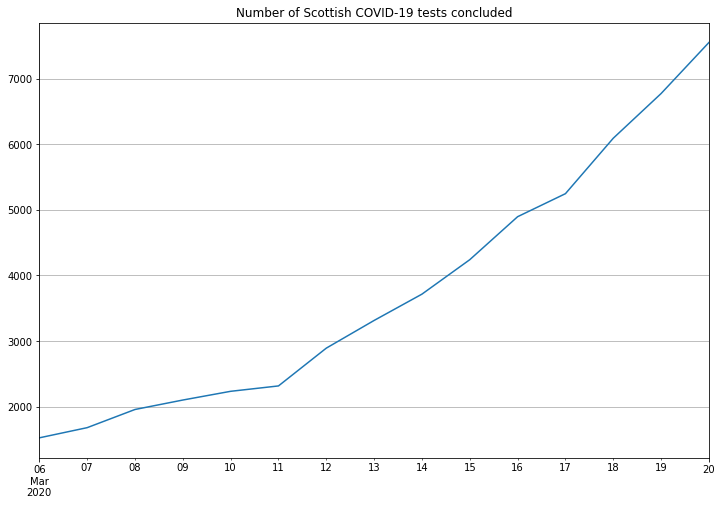

In [17]:
all_results.tests.plot(title='Number of Scottish COVID-19 tests concluded', figsize=(12,8), grid=True)

In [18]:
print("Daily increase in number of test concluded")
all_results.tests.diff()[1:].astype('int')

Daily increase in number of test concluded


2020-03-07    155
2020-03-08    277
2020-03-09    144
2020-03-10    133
2020-03-11     82
2020-03-12    576
2020-03-13    422
2020-03-14    401
2020-03-15    525
2020-03-16    655
2020-03-17    351
2020-03-18    845
2020-03-19    681
2020-03-20    778
Name: Tests concluded, dtype: int64

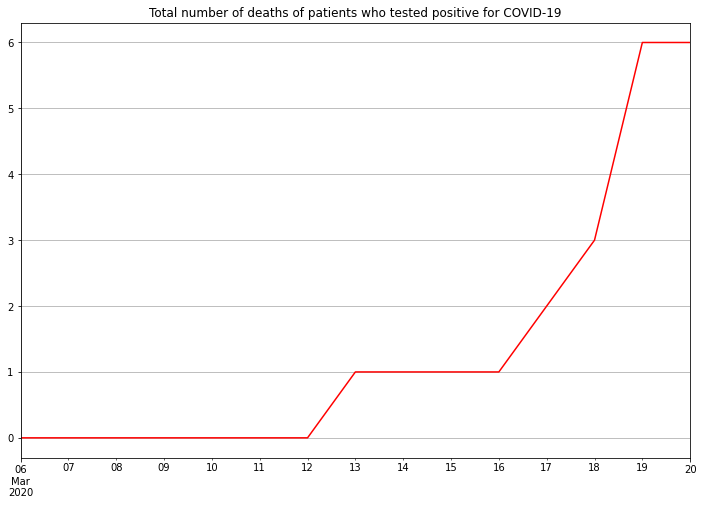

In [19]:
all_results.deaths.plot(color='r', title='Total number of deaths of patients who tested positive for COVID-19', grid=True, figsize=(12, 8))

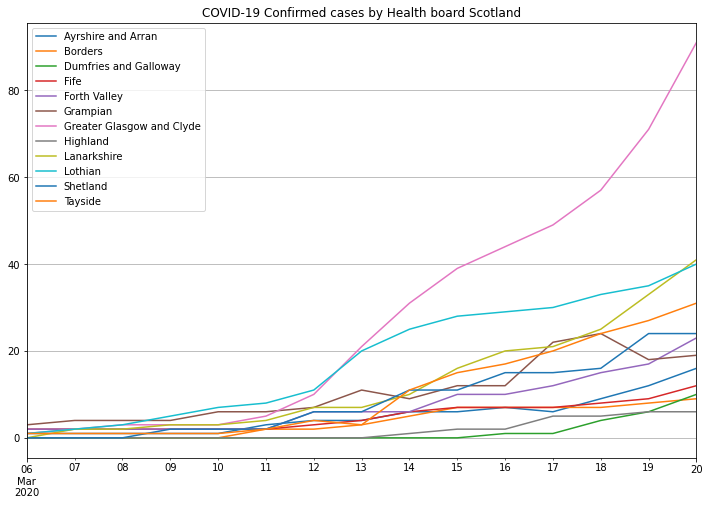

In [20]:
all_results.counts.plot(figsize=(12,8), title='COVID-19 Confirmed cases by Health board Scotland', grid=True)

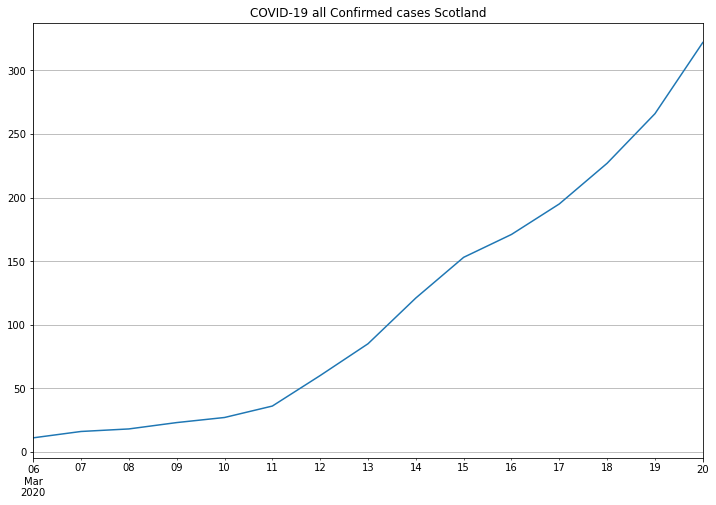

In [21]:
all_results.counts.sum(axis=1).plot(figsize=(12,8), title='COVID-19 all Confirmed cases Scotland', grid=True)

In [22]:
def calculate_percentage_increases(covid_data: pd.DataFrame) -> pd.DataFrame:
    """Approach gives 100% for first confirmed case, not ideal"""
    percentage_increases = []
    for index in range(1, len(covid_data)):
        percentage_increases.append(round(
            (covid_data.iloc[index] - covid_data.iloc[index - 1, :]) /covid_data.iloc[index, :] * 100 ,2))
    percentage_increases = pd.concat(percentage_increases, axis=1)
    percentage_increases.columns = covid_data.index[1:]
    percentage_increases.columns.name = 'Daily % increase'
    percentage_increases.index.name = 'Health Board'
    return percentage_increases

In [23]:
percentage_increases = calculate_percentage_increases(all_results.counts)
percentage_increases_numbers = percentage_increases.copy()
percentage_increases = percentage_increases.replace(100,'First Case Confirmed')
percentage_increases

Daily % increase,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20
Health Board,,,,,,,,,,,,,,
Ayrshire and Arran,0,0.00,0,0.00,66.67,25.00,0.00,33.33,0.00,14.29,-16.67,33.33,25.00,25.00
Borders,NaN,NaN,NaN,NaN,First Case Confirmed,0.00,33.33,40,28.57,0,0.00,0.00,12.50,11.11
Dumfries and Galloway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,First Case Confirmed,0.00,75.00,33.33,40.00
Fife,0,0.00,0,0.00,0,33.33,25.00,33.33,14.29,0,0.00,12.50,11.11,25.00
Forth Valley,0,0.00,0,0.00,0,66.67,0.00,0,40.00,0,16.67,20.00,11.76,26.09
Grampian,25,0.00,0,33.33,0,14.29,36.36,-22.22,25.00,0,45.45,8.33,-33.33,5.26
Greater Glasgow and Clyde,50,33.33,0,0.00,40,50.00,52.38,32.26,20.51,11.36,10.20,14.04,19.72,21.98
Highland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,First Case Confirmed,50.00,0,60.00,0.00,16.67,0.00
Lanarkshire,First Case Confirmed,0.00,33.33,0.00,25,42.86,0.00,30,37.50,20,4.76,16.00,24.24,19.51


In [24]:
min_days_present = (~percentage_increases.isna()).sum(axis=1)
min_days_present.name = 'Minimum number of days of confirmed cases'
min_days_present

Health Board
Ayrshire and Arran           14
Borders                      10
Dumfries and Galloway         5
Fife                         14
Forth Valley                 14
Grampian                     14
Greater Glasgow and Clyde    14
Highland                      7
Lanarkshire                  14
Lothian                      14
Shetland                     12
Tayside                      14
Name: Minimum number of days of confirmed cases, dtype: int64

In [25]:
mean_daily_increase_across_scotland = round(percentage_increases_numbers.mean(), 2)
mean_daily_increase_across_scotland.name = "Mean % increase Scotland wide"
mean_daily_increase_across_scotland.index.name = 'Mean Daily % increase'
print("Ignores the first confirmed case in each health board.")
mean_daily_increase_across_scotland

Ignores the first confirmed case in each health board.


Mean Daily % increase
2020-03-07    28.12
2020-03-08     8.33
2020-03-09    19.26
2020-03-10     6.88
2020-03-11    29.42
2020-03-12    37.61
2020-03-13    15.87
2020-03-14    34.99
2020-03-15    23.02
2020-03-16    15.63
2020-03-17    11.56
2020-03-18    17.60
2020-03-19    14.26
2020-03-20    16.61
Name: Mean % increase Scotland wide, dtype: float64

In [26]:
mean_daily_percent_increase_by_board = round(
    percentage_increases.mean(axis=1), 2)
mean_daily_percent_increase_by_board.name = "Mean % increase 6-20th March"
mean_daily_percent_increase_by_board.sort_values()

Health Board
Ayrshire and Arran           10.18
Tayside                      11.00
Borders                      12.22
Shetland                     13.28
Fife                         13.47
Grampian                     14.97
Lanarkshire                  16.10
Lothian                      19.50
Forth Valley                 20.13
Greater Glasgow and Clyde    24.68
Highland                     25.33
Dumfries and Galloway        37.08
Name: Mean % increase 6-20th March, dtype: float64

In [27]:
all_results

            Deaths of confirmed cases  Tests concluded
2020-03-06                          0             1525
2020-03-07                          0             1680
2020-03-08                          0             1957
2020-03-09                          0             2101
2020-03-10                          0             2234
2020-03-11                          0             2316
2020-03-12                          0             2892
2020-03-13                          1             3314
2020-03-14                          1             3715
2020-03-15                          1             4240
2020-03-16                          1             4895
2020-03-17                          2             5246
2020-03-18                          3             6091
2020-03-19                          6             6772
2020-03-20                          6             7550